# Homework 3
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers K-Means and mean shift methods for clustering and image segmentation.

In [1]:
# Setup
from __future__ import print_function
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from skimage import io
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

## Introduction
In this assignment, you will use clustering algorithms to segment images. You will then use these segmentations to identify foreground and background objects.

Your assignment will involve the following subtasks:
- **K-means clustering**: Understand the principle of kmeans and implement K-Means clustering.
- **Mean shift clustering**: Understand the principle of mean-shift and implement Mean Shift clustering.
- **Results comparison**: Try the above two methods on the image segmentation task and compare the performance.

## 1 K-means Clustering Algorithms (total 30 points)
K-Means clustering is an unsupervised learning algorithm. There is no labeled data for this clustering, unlike in supervised learning. K-Means performs the division of objects into clusters that share similarities and are dissimilar to the objects belonging to another cluster. The K-Means clustering algorithm is an iterative process where you are trying to minimize the distance of the data point from the average data point in the cluster.

<img src=./images/kmean_sample.gif width=100% />

reference: https://www.linkedin.com/pulse/k-means-clustering-its-real-use-case-surayya-shaikh

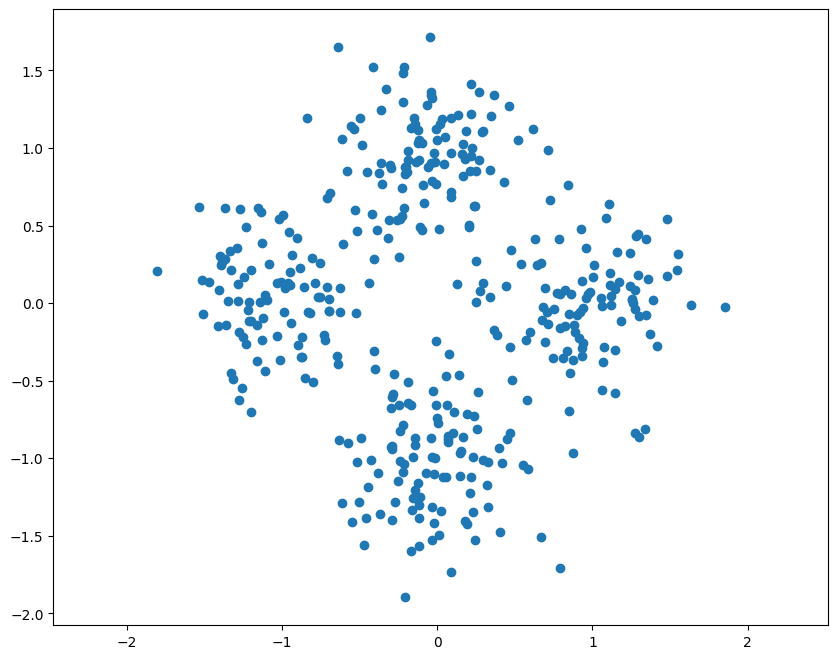

In [2]:
# Generate random data points for clustering

# Set seed for consistency
np.random.seed(0)

# Cluster 1
mean1 = [-1, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 1]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [1, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -1]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Merge two sets of data points
X = np.concatenate((X1, X2, X3, X4))

# Plot data points
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

### 1.1 K-Means Clustering (10 points)
As discussed in class, K-Means is one of the most popular clustering algorithms. We have provided skeleton code for K-Means clustering in the file `segmentation.py`. Your first task is to finish implementing **`kmeans`** in `segmentation.py`. This version uses nested for loops to assign points to the closest centroid and compute a new mean for each cluster.

We can manually implement the kmeans algorithm by looping through, but we can use numpy functions and broadcasting to make K-Means faster. This should run at least 10 times faster than the implementation of only `for looping`.

If you are interested, you can compare the time overhead of using broadcasting and for loops, and record them. (Optional, no score)

(400, 2)
kmeans running time: 0.081021 seconds.


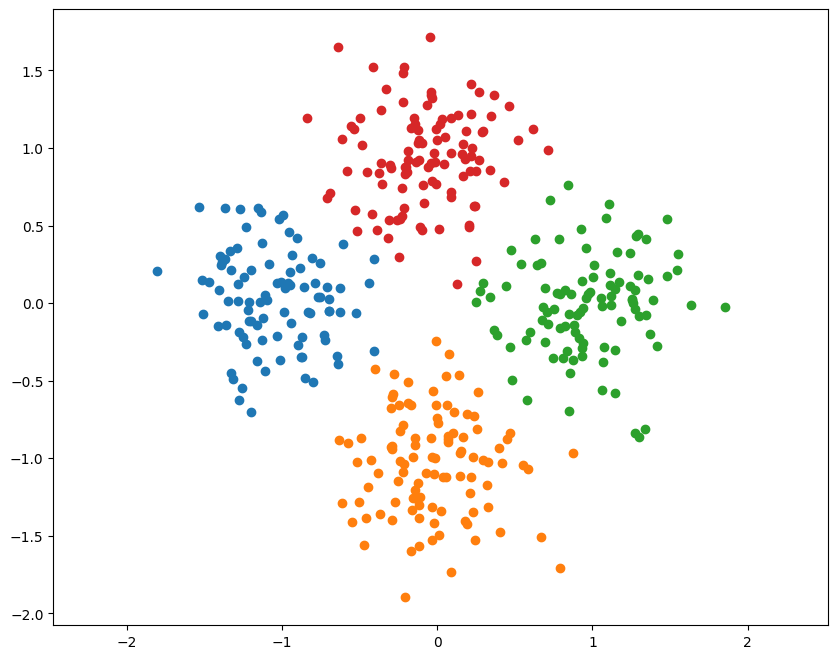

In [3]:
from segmentation import kmeans

np.random.seed(0)
start = time()
assignments = kmeans(X, 4)
end = time()

kmeans_runtime = end - start

print("kmeans running time: %f seconds." % kmeans_runtime)

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

### 1.2 K-Means Convergence (10 points)
Implementations of the K-Means algorithm will often have the parameter `num_iters` to define the maximum number of iterations the algorithm should run for. Consider that we opt to not include this upper bound on the number of iterations, and that we define the termination criterion of the algorithm to be when the cost $L$ stops changing.

Recall that $L$ is defined as the sum of squared distance between all points $x$ and their nearest cluster center $c$:

$$L = \sum_{i \in clusters}\sum_{x \in cluster_i} (x - c_i)^2$$

Show that for any set of points **$D$** and any number of clusters $k$, the K-Means algorithm will terminate in a finite number of iterations.

**Your answer here:**

本题相当于是去证明，如果以 $L$ 不再改变为迭代终止条件（不考虑迭代次数上限 `num_iters`），给定一组点集 $D$ 和任意的聚类数 $k$，K-Means 算法都将会在有限次迭代后终止。

首先，考虑到K-Means算法的工作原理，它的迭代过程中涉及两个主要步骤：分配步骤（Assignment step）和更新步骤（Update step）。在**分配步骤**中，算法会根据每个数据点x与其最近的聚类中心c的距离来将数据点分配给相应的聚类。在**更新步骤**中，算法会重新计算每个聚类的中心，通过计算每个聚类中所有数据点的平均值来得到新的聚类中心。

我们考虑 $L$ 的定义：

$$L = \sum_{i \in clusters}\sum_{x \in cluster_i} (x - c_i)^2$$

假设在进行了 $n$ 轮迭代后，$L$ 的大小为 $L_n$。现在对于第 $(n+1)$ 轮，先进行分配步骤，分配完成后 $L$ 的大小变为 $L_n^{'}$。由于分配过程是将数据点分配给距离更小的聚类中心，在这个过程中，距离总和只可能变小或者保持不变，不可能增大。因此我们有 $L_n^{'} \leq L_n$。

对于第 $(n+1)$ 轮的更新步骤，我们设更新完后的 $L$ 为$L_n^{''}$。并设 $L=C_1+C_2+C_3+...+C_k$，其中 $C_1 \sim C_k$ 是不同聚类中心内部的距离总和。显然有：

$$C_j = \sum_{x \in cluster_j} (x - c_j)^2 = \sum_{x \in cluster_j} (c_j - x)^2$$

求出 $C_j$ 关于$ c_j$ 的偏导，得到：

$$\frac{\partial C_j}{\partial c_j} = \sum_{x \in cluster_j} 2 \cdot (c_j - x)$$

故$\frac{\partial C_j}{\partial c_j} = 0$的时候，$c_j$的值恰好为当前聚类中所有点的平均值 $\overline{x_j}$ （也就是更新步骤计算出的新均值）。注意到，$c_j < \overline{x_j}$时，$\frac{\partial C_j}{\partial c_j} < 0$，$C_j$ 随$ c_j$的增大而减小；$c_j > \overline{x_j}$时，$\frac{\partial C_j}{\partial c_j} > 0$，$C_j$ 随$ c_j$的增大而增大。因此，当某个聚类中的所有点保持不变，并将聚类中心设置为当前聚类点的平均值时，能让 $C_j$ 取到最小值。

因此，在更新步骤，同样可推出，距离总和只可能变小或者保持不变，不可能增大。因此我们有 $L_{n+1}=L_n^{''} \leq L_n^{'} \leq L_n$。

所以可以进一步得到$L_{1} \geq L_{2} \geq L_{3} \geq L_{4} \geq ... \geq L_{n} \geq L_{n+1}$。$L$ 显然非负（即$L \geq 0$）。根据**极限的单调有界定理**，可以得到$\lim_{n \to \infty}L_n = P$（$P$ 为某一定常数）。

另一方面，由于计算机中，实数使用浮点数的方式来存储，存储位数和存储精度有限。因此在判定相等的时候，只要两个数的差距小于某个阈值即会认为相等。再结合 $\lim_{n \to \infty}L_n = P$（$P$ 为某一定常数），可知经过有限步骤后，计算机会判定 $L$ 不再改变，并终止迭代。

综上所述，即便不使用 `num_iters`，K-Means 算法仍会在有限次迭代后终止。

证毕.

### 1.3 Image Segmentation based on K-means (10 points)
When we use kmeans for image segmentation, the color information of pixels is used for clustering, so each of our pixels can be regarded as a vector composed of R, G, and B, and RGB is our color feature.

The specific process is similar to our example above, but the calculation object is changed from a scalar to a 3-dimensional vector.

Please implement the `kmean_color` function in `segmentation.py` and call it to complete the segmentation of color images. (very similar to `kmeans function`)

kmeans_clustering running time: 2.944412 seconds.


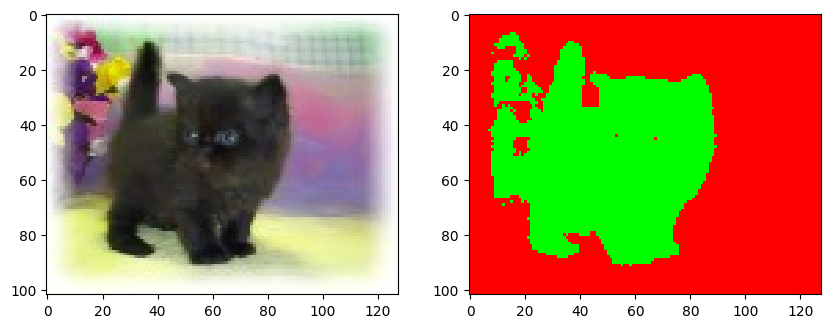

In [4]:
from segmentation import kmeans_color
img = io.imread('example.jpg')
#img = img[...,[2,1,0]]
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)
k=2
cluster_color=[[255,0,0],[0,255,0],[0,0,255],[[255,255,0]],[255,0,255],[[0,255,255]]]
start = time()
assignments = kmeans_color(img, k)
end = time()

print("kmeans_clustering running time: %f seconds." % (end - start))
res_img=np.array(img)
for i in range(k):
    res_img[assignments==i]=cluster_color[i]
plt.subplot(1,2,2)
plt.imshow(res_img)
plt.show()

We can try different values of k and number of iterations and observe the difference in the results.

## 2 Mean Shift Clustering (total 50 points)
### 2.1 Mean Shift
Mean shift is a procedure for locating the maxima—the modes—of a density function given discrete data sampled from that function.  This is an iterative method, and we start with an initial estimate $x$, Let a kernel function $K(x_{i}-x)$ be given. This function determines the weight of nearby points for re-estimation of the mean. Typically a Gaussian kernel on the distance to the current estimate is used, $K(x_{i}-x)=e^{-c||x_{i}-x||^{2}}$. The weighted mean of the density in the window determined by $K$ is:

$$ m(x)=\frac{\sum_{x_{i} \in N(x)} K(x_{i}-x) x_{i}}{\sum_{x_{i}\in N(x)}K(x_{i}-x)} $$

where $N(x)$ is the neighborhood of $x$, a set of points for which $K(x_{i}-x)\neq 0$. The difference $m(x)-x$ between mean and specific point is called mean shift in Fukunaga and Hostetler. The mean-shift algorithm now sets $x\leftarrow m(x)$, and repeats the extimation until $m(x)$ converges.

mean shift example: specific one sample:

It will "move" towards the direction with the highest density within a fixed range. "Move' in the segmentation is just an abstract way of saying that the point representing the pixel is more likely to belong to the category of the pixel with the highest density.

<img src=./images/mean-shift-vector.gif width=100% />

mean shift example: all samples:
<img src=./images/mean-shift.gif width=100% />


Let's use the meanshift function in sklearn to try it out on the previous example:

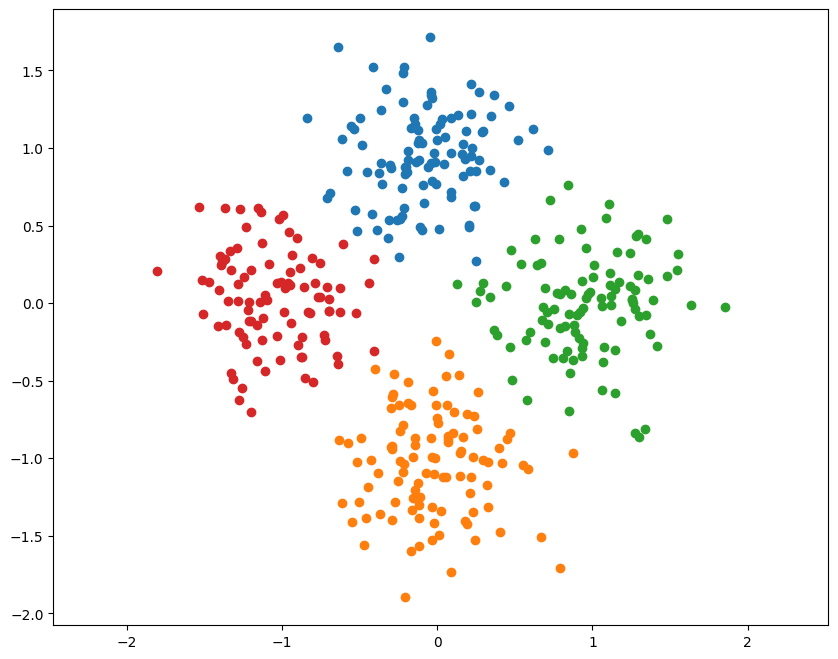

In [5]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=1000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
k=len(list(set(labels)))
for i in range(k):
    cluster_i = X[labels==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

### 2.2 Implementation of Mean Shift (30 points)
We try to implement the mean shift algorithm manually. the process is:

- **(1)**: Calculate the mean vector for each sample;
- **(2)**: Offset the mean vector from which samples are computed;
- **(3)**: Repeat the previous two processes, and set the iteration stop condition, such as the mean shift is less than a certain threshold;
- **(4)**: Samples that converge to the same point are considered to be members of the same cluster class

In [6]:
from segmentation import segmIm
img = io.imread('./example.jpg')

# 运行 Mean Shift 算法，超参可以自己调整
res_img=segmIm(img, 20)


Note: Since the mean shift algorithm usually calculates the mean vector for all points in the whole image, the convergence speed is slow. If the image is large, we generally perform compression processing. (Our example is already compressed)


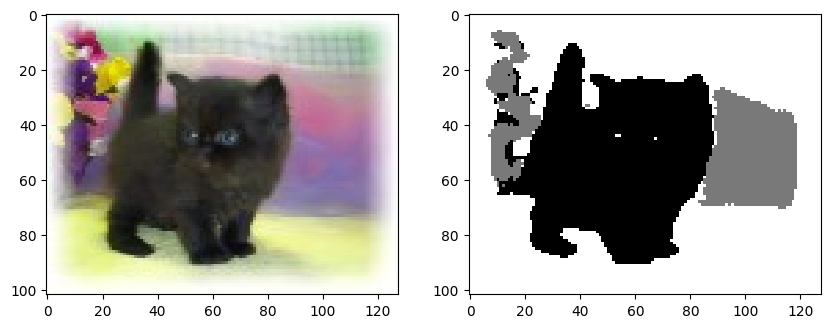

In [7]:
plt.close()
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(res_img)
#输出的是灰度图，并不是前景的mask
plt.show()

### 2.3 Calculate the performance (10 points)
Match the prediction result with gt pixel by pixel, finish the `compute_accuracy` function in the `segmentation.py`

In [8]:
from segmentation import compute_accuracy
from skimage import color
#Set the foreground to 0, the background to 0
pred_mask=res_img
gt=np.array(io.imread('./gt.png'))[:,:,:3]# Omit the fourth channel
gt=color.rgb2gray(gt)
gt_mask=(gt <= 0.5).astype(int)

#筛选前景，超参可调整
pred_mask=(pred_mask >= 0.5).astype(int)

acc=compute_accuracy(pred_mask, gt_mask)
print(acc)

0.9725796568627451


### 2.4 Question (10 points)
In the above attempts, it can be found that the clustering process of shift mean is slow when facing large images. Please give several methods to speed up the algorithm. (including pre-processing or post-processing)

**Your answer here:**

可以使用以下方法来加速 **shift mean** 的聚类过程：
- 预处理优化方法：
    - 对大图像提前进行压缩。例如，可以将大图像按比例缩小，以降低图像的分辨率。
    - 对大图像提前进行分割，划分为多个较小的区域，然后再对每个区域进行独立的聚类。
    - 数据降维：如果数据维度非常高，可以使用降维技术（如主成分分析）将数据降低到较低的维度。这可以减少计算量，并提高Mean-Shift的速度。
    - 数据采样：如果数据集很大，可以考虑对数据进行采样，选择一部分代表性的样本进行Mean-Shift。这样可以减少计算的复杂性，并在保留数据集结构的同时提高速度。
    - 核函数选择：Mean-Shift方法中的核函数选择也会影响速度。可以尝试使用简单的核函数（如高斯核函数）替代复杂的核函数。简化核函数可以减少计算量，并加速Mean-Shift的收敛速度。
    - 簇初始化：使用一些快速的聚类算法（如K-Means）来初始化簇的中心点。然后，将这些中心点作为Mean-Shift算法的初始点，可以加速算法的收敛速度。
- 后处理优化方法：
    - 聚类结果剪枝：在Mean-Shift的一轮迭代结束后，可以对聚类结果进行剪枝。如果某个聚类簇的样本数量太少，可以将其归并到邻近的簇中。这样可以减少聚类结果中的噪声，并减小簇的数量。
    - 并行计算：可以考虑使用并行计算技术（如多线程或分布式计算）来加速Mean-Shift的计算过程。将数据分成多个子集，并在不同的处理单元上并行计算，可以显著提高计算速度。
    - 簇合并：在Mean-Shift的一轮迭代结束后，可以对聚类结果进行簇合并。如果存在非常接近的簇，则可以将它们合并成一个簇，从而减少最终的簇的数量。这样可以降低后处理的计算复杂度。
    - 收敛条件优化：Mean-Shift方法中的收敛条件可以调整。可以根据实际需求降低收敛精度，从而减少迭代次数。这样可以加速Mean-Shift的收敛过程。
    - 算法上优化。例如，将End Point附近半径范围内的所有点都归属为与End Point相同的Cluster，或者将Mean Shift移动路径上的r/c范围内的所有Point都归属于与End Point相同的Cluster。

## 3 Comparison of kmeans and mean shift (20 points)
We want to specifically compare the performance of kmeans and mean shift methods on foreground segmentation.

For foreground segmentation, we only need to segment certain specific objects, such as cats, dogs, beds, and so on. The objects that need to be segmented on the small amount of data we use for comparison are all cats, but the number of cats is variable.

For mean shift, two clusters are generated most of the time in our task (There are many categories, choose the appropriate category as the prospect according to your needs), and for kmeans, we only need to set k=2.

Please use the previously implemented code in the following block to traverse the entire dataset and output the accuracy results of using the kmeans and mean shift methods on each image.

It should be emphasized that because the mean shift algorithm is slow, you can use the image compression method to compress the image first, but the aspect ratio of the image cannot be changed (our recommendation is 128*102)

How to determine which of the outcomes is the prediction we want?
   It can be calculated with that the max area of overlapping of the groundtruth or to observe manually.

Note: There is rgb noise in the ground truth image, it is not a complete black and white image, pay attention to the threshold of binarization.

Note: allow flexible adjustment of hyperparameters for different images.

And visualize each image: original; kmeans result; mean shift result.

In [9]:
import os
image_files=os.listdir('./data/imgs')
images=[]
gts=[]
masks=[]
for i in image_files:
    images.append(os.path.join('./data/imgs',i))
    gts.append(os.path.join('./data/gt',i))
for i in range(len(images)):
    ### YOUR CODE HERE # 10 points
    pass
    img = io.imread(images[i])
    #kmeans
    km_mask=kmeans_color(img, 2)
    km_mask=(km_mask >= 0.5).astype(int)
    #mean shift
    ms_mask=segmIm(img, 2)
    ms_mask=(ms_mask >= 0.5).astype(int)
    #gt
    gt=np.array(io.imread(gts[i]))[:,:,:3]# Omit the fourth channel
    gt=color.rgb2gray(gt)
    gt_mask=(gt <= 0.5).astype(int)
    ### END YOUR CODE
    #kmeans
    masks.append([km_mask,ms_mask,gt_mask])
    #output three masks

visualize:

0  kmeans:  0.8305759803921569  , mean_shift:  0.8220741421568627
1  kmeans:  0.9303768382352942  , mean_shift:  0.8740808823529411
2  kmeans:  0.9828431372549019  , mean_shift:  0.9801623774509803
3  kmeans:  0.6982230392156863  , mean_shift:  0.6681985294117647
4  kmeans:  0.774203431372549  , mean_shift:  0.7630974264705882


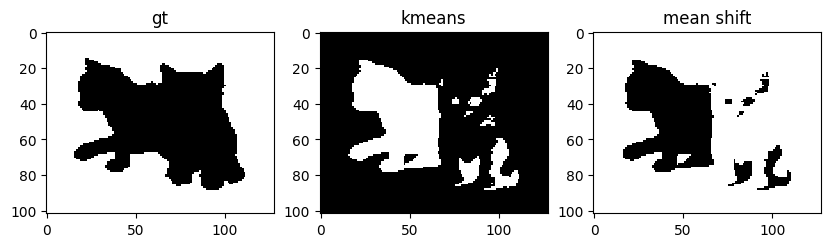

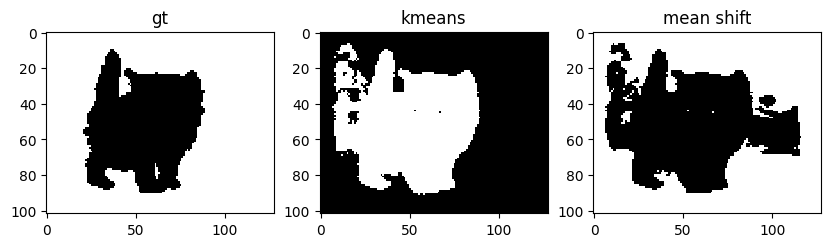

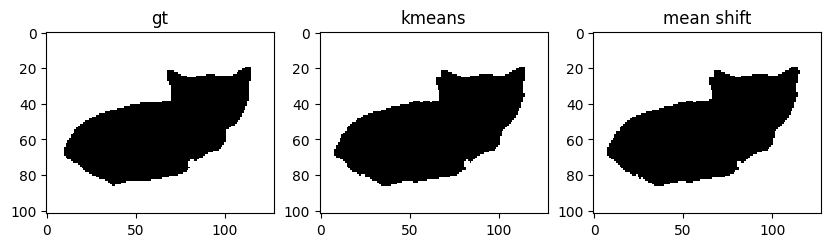

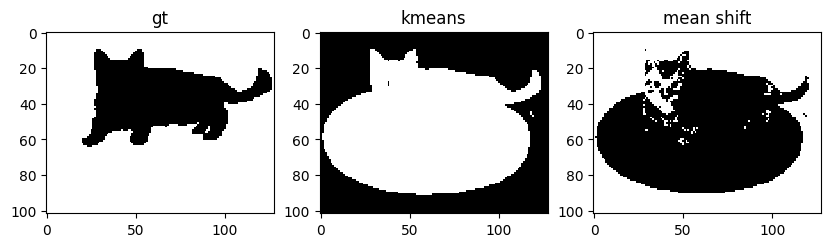

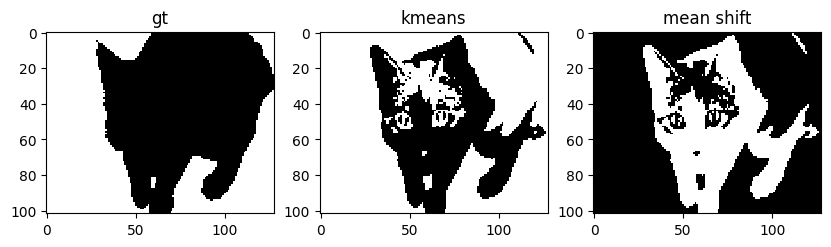

In [10]:
#visualize
plt.figure()

for i in range(len(masks)):
    ### YOUR CODE HERE # 10 points
    km_acc=compute_accuracy(masks[i][2], masks[i][0])
    ms_acc=compute_accuracy(masks[i][2], masks[i][1])
    pass
    ### END YOUR CODE
    print(i, " kmeans: ", km_acc, ' , mean_shift: ', ms_acc)

for i in range(len(masks)):
    plt.subplot(1, 3, 1)
    plt.imshow(masks[i][2])
    plt.title('gt')
    plt.subplot(1, 3, 2)
    plt.imshow(masks[i][0])
    plt.title('kmeans')
    plt.subplot(1, 3, 3)
    plt.imshow(masks[i][1])
    plt.title('mean shift')
    plt.show()


visualize the results, for example:
<img src=./images/visual.png width=100% />